# **Observation**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.coordinates import AltAz, EarthLocation, SkyCoord
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import get_sun
from astropy.coordinates import get_body
from astropy.visualization import astropy_mpl_style, quantity_support

# Visualisation
plt.style.use(astropy_mpl_style)
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x218ddbbdd10>

# Define your observatories

In [2]:
# observatory location (Ondrejov and La Silla)
ondrejov = EarthLocation(lat=49.915175*u.deg, lon=14.780994*u.deg, height=500*u.m)
lasilla = EarthLocation(lat=-29.261165622*u.deg, lon=-70.731330408*u.deg, height=2400*u.m)

ondrejov_utcoffset = +2*u.hour  # Central Europian Time # 31.3 switching to +2 (from +1) (summer time)
lasilla_utcoffset = -3*u.hour # 2.4 switching to -3 (from -4) (summer time)

# Entering data:


In [3]:
# Enter data about the object (in degres):
object_ra =180.7169088
object_dec = 55.28139516
object_name = '51263552'

date = '2024-2-27 00:00:00'
# in format 'yyyy-mm-dd 00:00:00' as midnight of the night you want to observe

obs_location = ondrejov
# enter: ondrejov or lasilla

period = 1/3.61
#in days

M0 =2459582.30874736
# as JD (everything without units)

# ------------------------------------------------------------

C:\Users\admin\anaconda3\envs\astro\Lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "taiutc" yielded 7 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


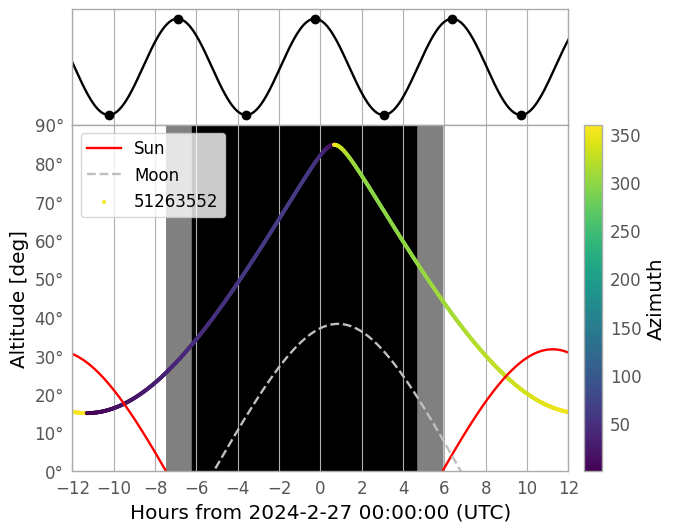

In [4]:
if obs_location == ondrejov:
    offset = ondrejov_utcoffset
elif obs_location == lasilla:
    offset = lasilla_utcoffset
else:
    print('Location not found')

# star position in right ascension, declination
c_icrs = SkyCoord(ra = object_ra*u.degree, dec = object_dec*u.degree, frame='icrs')

midnight = Time(date)

delta_midnight = np.linspace(-12, 12, 1000)*u.hour
delta_midnight_jd = np.linspace(0, 1, 1000)*u.d

# transforming to altaz coordinates
frame_night = AltAz(obstime = midnight + delta_midnight, location = obs_location)
c_altaz = c_icrs.transform_to(frame_night)

# sun rising and setting (location on the sky)
sun_altaz = get_sun(midnight+delta_midnight).transform_to(frame_night)

# moon rising and setting (location on the sky)
moon_altaz = get_body("moon", midnight+delta_midnight).transform_to(frame_night)

# phase of the object on that night
time = np.array((midnight -0.5*u.d).jd) + np.array(delta_midnight_jd)
ph1 = (np.sin(2*np.pi*(time - M0)/period - np.pi/2)+1)/2

date_jd_start = float((midnight - 0.5*u.d).jd)
date_jd_end = float((midnight + 0.5*u.d).jd)
a = M0

while a <= date_jd_start:
    a = a + period
if a > date_jd_start:
    a = a - period # a is the last minimum before the desired date
#print(date_jd_start, date_jd_end)

points = np.zeros(666)
i = 1
b = a

while b <= date_jd_end:
    points[i - 1] = b
    b = a + (period/2) * i
    i = i + 1

condition = points >= date_jd_start
points_at_date = points[condition]

phases_at_points = np.zeros(len(points_at_date))
for i in range(len(points_at_date)):
    phases_at_points[i] = ((points_at_date[i] - M0)/period) - int((points_at_date[i] - M0)/period)
#phases_at_points

ph1_at_points = np.zeros(len(points_at_date))
for i in range(len(points_at_date)):
    ph1_at_points[i] = (np.sin(2*np.pi*(points_at_date[i] - M0)/period - np.pi/2)+1)/2
#ph1_at_points

time_at_date = np.array((Time(points_at_date*u.d, format='jd') - midnight.jd).jd) * 24
#time_at_date

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [1, 3],'hspace': 0})

ax1.plot(delta_midnight, ph1, color='black')
ax1.scatter(time_at_date, ph1_at_points, color = 'black')
ax1.yaxis.tick_right()
#ax1.set_yticks(np.arange(0, 1.1, step=0.25))
ax1.set_yticks([])
ax1.set_ylim(-0.1, 1.1)
ax1.grid(True)

ax2.plot(delta_midnight, sun_altaz.alt, color='r', label='Sun')
ax2.plot(delta_midnight, moon_altaz.alt, color=[0.75]*3, ls='--', label='Moon')
scatter = ax2.scatter(delta_midnight, c_altaz.alt,
            c=c_altaz.az.value, label=object_name, lw=0, s=8,
            cmap='viridis')
ax2.fill_between(delta_midnight, 0*u.deg, 90*u.deg,
                 sun_altaz.alt < 0*u.deg, color='0.5', zorder=0)
ax2.fill_between(delta_midnight, 0*u.deg, 90*u.deg,
                 sun_altaz.alt < -12*u.deg, color='k', zorder=0)

cbar = fig.colorbar(scatter, ax=(ax1, ax2))
cbar.set_label('Azimuth')
cbar.ax.set_position([ax2.get_position().x1 + 0.02,  # X position (right of the plot)
                      ax2.get_position().y0,          # Y position (bottom of the plot)
                      0.05,                            # Width of the colorbar
                      ax2.get_position().height])

ax2.legend(loc='upper left')
ax2.set_xlim(-12*u.h, 12*u.h)
ax2.set_xticks((np.arange(13)*2-12)*u.h)
ax2.set_ylim(0, 90)
ax2.set_xlabel('Hours from {} (UTC)'.format(date))
ax2.set_ylabel('Altitude [deg]')
ax2.grid(which = 'major', axis = 'y')
#ax2.grid(False) # if you want plot with the grid

### Phases observable during the night

In [5]:
# hours from midnight converted to actual time
timedelta_values = [pd.to_timedelta(str(hour) + ' hours') for hour in time_at_date]
hours_values = [str(timedelta).split(' ')[-1].lstrip('+') for timedelta in timedelta_values]

table = pd.DataFrame(
    {
    'phase': phases_at_points,
    'date_jd': points_at_date,
    'date_h_local': hours_values,
    'date_h': time_at_date,
    }
)

# sunset sunrise times to better select which phases to use
sun = sun_altaz.alt < 0
sunset_i = np.where(sun == 1)[0][0]
sunrise_i = np.where(sun == 1)[0][-1]

sunrise = delta_midnight[sunrise_i].value
sunset = delta_midnight[sunset_i].value

def highlight_row(x):
    if x['date_h'] > sunset and x['date_h'] < sunrise:
        return ['color: #1F968BFF']*len(x)
    else:
        return ['']*len(x)
table2 = table.style.apply(highlight_row, axis=1)
table2

,phase,date_jd,date_h_local,date_h
0,0.000002,2460367.073291,13:46:09.324856996,-10.230743
1,0.500002,2460367.211795,17:05:36.083847286,-6.906643
2,0.000002,2460367.350299,20:25:02.842837572,-3.582544
3,0.500002,2460367.488803,23:44:29.601868092,-0.258444
4,0.000002,2460367.627307,03:03:56.360858382,3.065656
5,0.500002,2460367.765812,06:23:23.119848668,6.389756
6,0.000002,2460367.904316,09:42:49.878838954,9.713855
